<a href="https://colab.research.google.com/github/ellacharmed/machine-learning-zoomcamp/blob/week08/08-deep-learning/notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 0

Autosave disabled


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tensorflow as tf
import timeit

start_time = timeit.timeit()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

<tf.Tensor: shape=(), dtype=float32, numpy=2862.6367>

In [3]:
start_time = timeit.default_timer()

# 8. Neural networks and deep learning

This week, we'll learn about neural nets and build a model
for classifying images of clothes


## 8.1 Fashion classification

Dataset:

* Full: https://github.com/alexeygrigorev/clothing-dataset
* Small: https://github.com/alexeygrigorev/clothing-dataset-small

Links:

* https://cs231n.github.io/

## 8.2 TensorFlow and Keras

* Installing TensorFlow
* Loading images

In [4]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 14.08 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
from tensorflow.keras.preprocessing.image import load_img

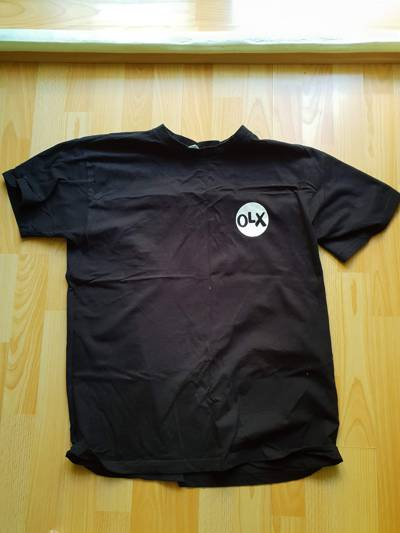

In [8]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [9]:
img = load_img(fullname, target_size=(299, 299))

In [10]:
x = np.array(img)
x.shape

(299, 299, 3)

## 8.3 Pre-trained convolutional neural networks

* Imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/


In [11]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [12]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

91884032/91884032 [==============================] - 5s 0us/step


In [13]:
X = np.array([x])

In [14]:
X.shape

(1, 299, 299, 3)

In [15]:
X = preprocess_input(X)

In [16]:
pred = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [17]:
decode_predictions(pred)

35363/35363 [==============================] - 0s 0us/step


[[('n03595614', 'jersey', 0.681964),
  ('n02916936', 'bulletproof_vest', 0.038139928),
  ('n04370456', 'sweatshirt', 0.03432469),
  ('n03710637', 'maillot', 0.01135421),
  ('n04525038', 'velvet', 0.0018453539)]]

## 8.4 Convolutional neural networks

* Types of layers: convolutional and dense
* Convolutional layers and filters
* Dense layers

There are more layers. Read here: https://cs231n.github.io/

## 8.5 Transfer learning

* Reading data with `ImageDataGenerator`
* Train `Xception` on smaller images (150x150)

(Better to run it with a GPU)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [20]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [21]:
X, y = next(train_ds)

In [22]:
y[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [23]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 341 images belonging to 10 classes.


In [24]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False



inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

83683744/83683744 [==============================] - 5s 0us/step


In [25]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [26]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)
# 1min

Epoch 1/10
96/96 [==============================] - 16s 119ms/step - loss: 1.2300 - accuracy: 0.6711 - val_loss: 0.9982 - val_accuracy: 0.7683
Epoch 2/10
96/96 [==============================] - 9s 97ms/step - loss: 0.5561 - accuracy: 0.8198 - val_loss: 0.8644 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 10s 107ms/step - loss: 0.3477 - accuracy: 0.8787 - val_loss: 0.8318 - val_accuracy: 0.7889
Epoch 4/10
96/96 [==============================] - 10s 100ms/step - loss: 0.2779 - accuracy: 0.9042 - val_loss: 0.8829 - val_accuracy: 0.7918
Epoch 5/10
96/96 [==============================] - 9s 98ms/step - loss: 0.1889 - accuracy: 0.9322 - val_loss: 0.8943 - val_accuracy: 0.8270
Epoch 6/10
96/96 [==============================] - 9s 94ms/step - loss: 0.1121 - accuracy: 0.9612 - val_loss: 0.8511 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 8s 87ms/step - loss: 0.0624 - accuracy: 0.9817 - val_loss: 0.9319 - val_accuracy: 0.8152
Epoch 8

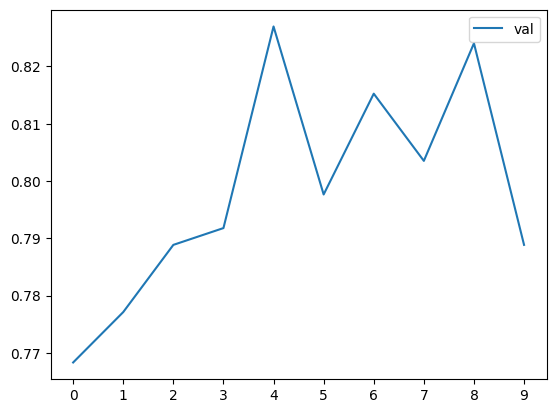

In [27]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## 8.6 Adjusting the learning rate

* What's the learning rate
* Trying different values

In [28]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [29]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()
# 7mins

0.0001
Epoch 1/10
96/96 [==============================] - 13s 104ms/step - loss: 1.9235 - accuracy: 0.3853 - val_loss: 1.5920 - val_accuracy: 0.5132
Epoch 2/10
96/96 [==============================] - 9s 98ms/step - loss: 1.4059 - accuracy: 0.5623 - val_loss: 1.2457 - val_accuracy: 0.6041
Epoch 3/10
96/96 [==============================] - 8s 87ms/step - loss: 1.1615 - accuracy: 0.6274 - val_loss: 1.0572 - val_accuracy: 0.6804
Epoch 4/10
96/96 [==============================] - 9s 98ms/step - loss: 1.0163 - accuracy: 0.6773 - val_loss: 0.9398 - val_accuracy: 0.7126
Epoch 5/10
96/96 [==============================] - 9s 96ms/step - loss: 0.9197 - accuracy: 0.7044 - val_loss: 0.8673 - val_accuracy: 0.7419
Epoch 6/10
96/96 [==============================] - 9s 89ms/step - loss: 0.8490 - accuracy: 0.7259 - val_loss: 0.8100 - val_accuracy: 0.7537
Epoch 7/10
96/96 [==============================] - 10s 99ms/step - loss: 0.7933 - accuracy: 0.7477 - val_loss: 0.7674 - val_accuracy: 0.7654
Epo

In [30]:
del scores[0.1]
del scores[0.0001]

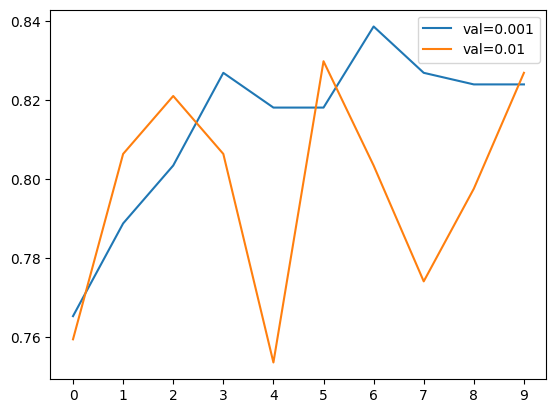

In [31]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [32]:
learning_rate = 0.001

## 8.7 Checkpointing

* Saving the best model only
* Training a model with callbacks

In [33]:
model.save_weights('model_v1.h5', save_format='h5')

In [34]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [35]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)
# 1mins

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.1139 - accuracy: 0.6294

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 14s 110ms/step - loss: 1.1139 - accuracy: 0.6294 - val_loss: 0.6924 - val_accuracy: 0.7889
Epoch 2/10
96/96 [==============================] - 13s 140ms/step - loss: 0.6387 - accuracy: 0.7872 - val_loss: 0.6191 - val_accuracy: 0.7889
Epoch 3/10
96/96 [==============================] - 10s 101ms/step - loss: 0.5140 - accuracy: 0.8299 - val_loss: 0.5682 - val_accuracy: 0.8358
Epoch 4/10
96/96 [==============================] - 8s 87ms/step - loss: 0.4342 - accuracy: 0.8628 - val_loss: 0.5390 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 9s 93ms/step - loss: 0.3785 - accuracy: 0.8833 - val_loss: 0.5276 - val_accuracy: 0.8358
Epoch 6/10
96/96 [==============================] - 9s 97ms/step - loss: 0.3318 - accuracy: 0.9022 - val_loss: 0.5276 - val_accuracy: 0.8240
Epoch 7/10
96/96 [==============================] - 9s 92ms/step - loss: 0.2965 - accuracy: 0.9198 - val_loss: 0.5125 - val_accuracy: 0.8270
Epoch 8/10
96/96 [

## 8.8 Adding more layers


* Adding one inner dense layer
* Experimenting with different sizes of inner layer

In [36]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

    outputs = keras.layers.Dense(10)(inner)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [37]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()
# 5mins

10
Epoch 1/10
96/96 [==============================] - 17s 139ms/step - loss: 1.5891 - accuracy: 0.4677 - val_loss: 1.2644 - val_accuracy: 0.5601
Epoch 2/10
96/96 [==============================] - 9s 93ms/step - loss: 1.0853 - accuracy: 0.6317 - val_loss: 0.9945 - val_accuracy: 0.6686
Epoch 3/10
96/96 [==============================] - 9s 97ms/step - loss: 0.8543 - accuracy: 0.6975 - val_loss: 0.8385 - val_accuracy: 0.6921
Epoch 4/10
96/96 [==============================] - 9s 95ms/step - loss: 0.6748 - accuracy: 0.7787 - val_loss: 0.7057 - val_accuracy: 0.7625
Epoch 5/10
96/96 [==============================] - 9s 89ms/step - loss: 0.5355 - accuracy: 0.8360 - val_loss: 0.6711 - val_accuracy: 0.7801
Epoch 6/10
96/96 [==============================] - 10s 99ms/step - loss: 0.4550 - accuracy: 0.8660 - val_loss: 0.6282 - val_accuracy: 0.7889
Epoch 7/10
96/96 [==============================] - 9s 89ms/step - loss: 0.3942 - accuracy: 0.8892 - val_loss: 0.6237 - val_accuracy: 0.7977
Epoch 8

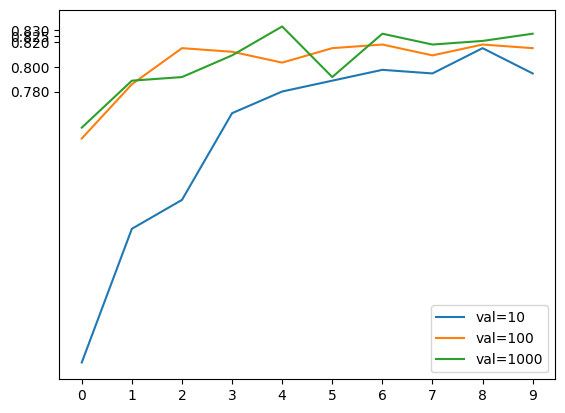

In [38]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

## 8.9 Regularization and dropout

* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [39]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [40]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()
# 19mins

0.0
Epoch 1/30
96/96 [==============================] - 13s 105ms/step - loss: 0.9501 - accuracy: 0.6796 - val_loss: 0.7031 - val_accuracy: 0.7625
Epoch 2/30
96/96 [==============================] - 9s 90ms/step - loss: 0.5240 - accuracy: 0.8198 - val_loss: 0.6380 - val_accuracy: 0.7625
Epoch 3/30
96/96 [==============================] - 13s 136ms/step - loss: 0.3452 - accuracy: 0.8879 - val_loss: 0.5561 - val_accuracy: 0.8182
Epoch 4/30
96/96 [==============================] - 12s 124ms/step - loss: 0.2450 - accuracy: 0.9286 - val_loss: 0.5634 - val_accuracy: 0.8123
Epoch 5/30
96/96 [==============================] - 9s 92ms/step - loss: 0.1707 - accuracy: 0.9583 - val_loss: 0.5677 - val_accuracy: 0.8182
Epoch 6/30
96/96 [==============================] - 9s 91ms/step - loss: 0.1207 - accuracy: 0.9707 - val_loss: 0.5871 - val_accuracy: 0.8123
Epoch 7/30
96/96 [==============================] - 9s 97ms/step - loss: 0.0952 - accuracy: 0.9811 - val_loss: 0.5768 - val_accuracy: 0.8123
Epo

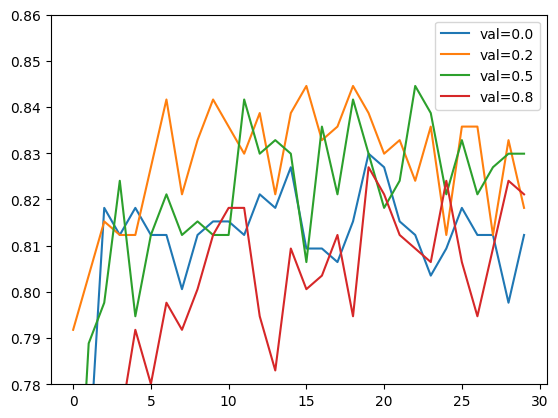

In [43]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

## 8.10 Data augmentation

* Different data augmentations
* Training a model with augmentations
* How to select data augmentations?

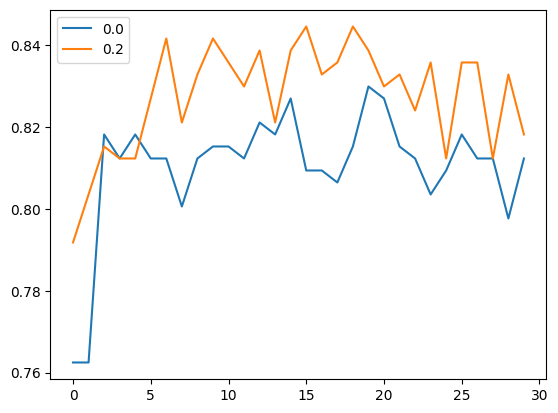

In [44]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()
#plt.plot(hist['accuracy'], label=('train=%s' % droprate))

In [45]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [47]:
%timeit
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)
# 7mins

Epoch 1/50
96/96 [==============================] - 13s 110ms/step - loss: 1.0486 - accuracy: 0.6450 - val_loss: 0.6768 - val_accuracy: 0.7801
Epoch 2/50
96/96 [==============================] - 9s 96ms/step - loss: 0.6037 - accuracy: 0.7907 - val_loss: 0.6197 - val_accuracy: 0.7977
Epoch 3/50
96/96 [==============================] - 8s 85ms/step - loss: 0.4510 - accuracy: 0.8393 - val_loss: 0.5486 - val_accuracy: 0.8123
Epoch 4/50
96/96 [==============================] - 9s 99ms/step - loss: 0.3658 - accuracy: 0.8683 - val_loss: 0.5722 - val_accuracy: 0.7977
Epoch 5/50
96/96 [==============================] - 9s 93ms/step - loss: 0.2937 - accuracy: 0.9058 - val_loss: 0.5228 - val_accuracy: 0.8328
Epoch 6/50
96/96 [==============================] - 9s 92ms/step - loss: 0.2305 - accuracy: 0.9263 - val_loss: 0.5947 - val_accuracy: 0.7859
Epoch 7/50
96/96 [==============================] - 9s 94ms/step - loss: 0.1875 - accuracy: 0.9459 - val_loss: 0.5294 - val_accuracy: 0.8446
Epoch 8/50


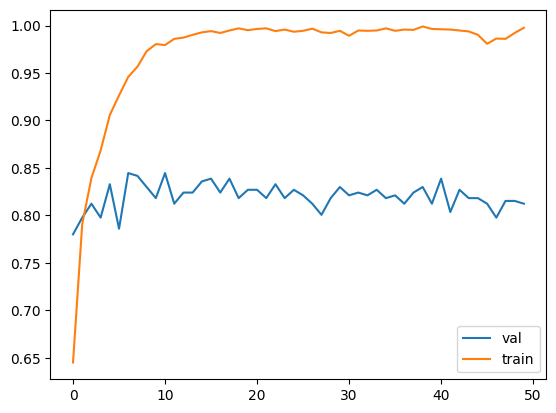

In [48]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## 8.11 Training a larger model

* Train a 299x299 model

In [49]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [50]:
input_size = 299

In [51]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [52]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',  # v4: droprate, augmentation, bigger size
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [53]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])
# mins

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.7379

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 88s 859ms/step - loss: 0.7921 - accuracy: 0.7379 - val_loss: 0.4945 - val_accuracy: 0.8328
Epoch 2/50
96/96 [==============================] - 86s 901ms/step - loss: 0.4468 - accuracy: 0.8520 - val_loss: 0.3928 - val_accuracy: 0.8710
Epoch 3/50
96/96 [==============================] - 79s 823ms/step - loss: 0.3815 - accuracy: 0.8693 - val_loss: 0.3804 - val_accuracy: 0.8651
Epoch 4/50
96/96 [==============================] - 81s 842ms/step - loss: 0.3315 - accuracy: 0.8833 - val_loss: 0.3629 - val_accuracy: 0.8680
Epoch 5/50
96/96 [==============================] - 79s 824ms/step - loss: 0.3027 - accuracy: 0.8905 - val_loss: 0.3548 - val_accuracy: 0.8768
Epoch 6/50
96/96 [==============================] - 79s 824ms/step - loss: 0.2761 - accuracy: 0.9078 - val_loss: 0.3641 - val_accuracy: 0.8856
Epoch 7/50
96/96 [==============================] - 81s 838ms/step - loss: 0.2494 - accuracy: 0.9146 - val_loss: 0.3511 - val_accuracy: 0.8856
Epoch 8/50

## 8.12 Using the model

* Loading the model
* Evaluating the model
* Getting predictions

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [55]:
import tensorflow as tf
from tensorflow import keras

In [56]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [59]:
!ls

clothing-dataset-small	 xception_v1_03_0.836.h5    xception_v4_1_06_0.886.h5
model_v1.h5		 xception_v4_1_01_0.833.h5  xception_v4_1_10_0.894.h5
sample_data		 xception_v4_1_02_0.871.h5
xception_v1_01_0.789.h5  xception_v4_1_05_0.877.h5


In [60]:
model = keras.models.load_model('xception_v4_1_10_0.894.h5')

In [61]:
model.evaluate(test_ds)

12/12 [==============================] - 5s 388ms/step - loss: 0.2850 - accuracy: 0.9059


[0.28501975536346436, 0.9059139490127563]

In [62]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [63]:
img = load_img(path, target_size=(299, 299))

In [64]:
import numpy as np

In [65]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [66]:
X = preprocess_input(X)

In [67]:
pred = model.predict(X)

1/1 [==============================] - 1s 735ms/step


In [68]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [69]:
dict(zip(classes, pred[0]))

{'dress': -2.9179976,
 'hat': -6.40855,
 'longsleeve': -1.273788,
 'outwear': -0.92349994,
 'pants': 10.008053,
 'shirt': -1.8279577,
 'shoes': -4.9518695,
 'shorts': 4.089724,
 'skirt': -4.761101,
 't-shirt': -2.6162796}

## 8.13 Summary

* We can use pre-trained models for general image classification
* Convolutional layers let us turn an image into a vector
* Dense layers use the vector to make the predictions
* Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
* First, train a small model (150x150) before training a big one (299x299)
* Learning rate - how fast the model trians. Fast learners aren't always best ones
* We can save the best model using callbacks and checkpointing
* To avoid overfitting, use dropout and augmentation

## 8.14 Explore more

* Add more data, e.g. Zalando, etc (ADD LINKS)
* Albumentations - another way of generating augmentations
* Use PyTorch or MXNet instead of TensorFlow/Keras
* In addition to Xception, there are others architectures - try them

Other projects:

* cats vs dogs
* Hotdog vs not hotdog
* Category of images



In [70]:
# Run the op several times.
print('Time (s) to run notebook in Colab with T4 hosted runtime.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to run notebook in Colab with T4 hosted runtime.
CPU (s):
4.993118461001359
GPU (s):
0.10068432399930316
GPU speedup over CPU: 49x


[source for timeit snippet](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Tensorflow_with_GPU)

In [71]:
import datetime

def days_hours_minutes(td):
    return td.seconds//3600, (td.seconds//60)%60

elapsed = timeit.default_timer() - start_time
hours, mins = days_hours_minutes(datetime.timedelta(seconds=elapsed))

print(f"The Colab notebook completion time  is : {hours} hours and {mins} minutes")

The Colab notebook completion time  is : 2 hours and 19 minutes
